In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/22472
# 标题：高频因子探索——动量交易

import pandas as pd
import numpy as np
from jqdata import *
import datetime 
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')


In [2]:
start_date = '2017-01-01'
end_date = '2019-09-05'

train_percent = 0.5
sel_percent = [0.8,0.98]
cut_layer = 10

stocks = get_index_stocks('000300.XSHG')

In [3]:
def get_tradeday_list(start, end, frequency=None, count=None):
    '''
    获取日期列表
    input:
    start:str or datetime,起始时间，与count二选一
    end:str or datetime，终止时间
    frequency:
        str: day,month,quarter,halfyear,默认为day
        int:间隔天数
    count:int,与start二选一，默认使用start
    '''
    if isinstance(frequency, int):
        all_trade_days = get_trade_days(start, end)
        trade_days = all_trade_days[::frequency]
        days = [datetime.datetime.strftime(i, '%Y-%m-%d') for i in trade_days]
        return days

    if count != None:
        df = get_price('000001.XSHG', end_date=end, count=count)
    else:
        df = get_price('000001.XSHG', start_date=start, end_date=end)
    if frequency == None or frequency == 'day':
        days = df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            days = df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month'] == '01') | (df['month'] == '04') | (df['month'] == '07') | (df['month'] == '10')]
            days = df.drop_duplicates('year-month').index
        elif frequency == 'halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month'] == '01') | (df['month'] == '06')]
            days = df.drop_duplicates('year-month').index
    trade_days = [datetime.datetime.strftime(i, '%Y-%m-%d') for i in days]
    return trade_days


def find_max_drawdown(returns):
    #returns 为cumprod收益
    # 定义最大回撤的变量
    result = 0
    # 记录最高的回报率点
    historical_return = 0
    # 遍历所有日期
    for i in range(len(returns)):
        # 最高回报率记录
        historical_return = max(historical_return, returns[i])
        # 最大回撤记录
        drawdown = 1 - (returns[i]) / (historical_return)
        # 记录最大回撤
        result = max(drawdown, result)
    # 返回最大回撤值
    return result

In [4]:
date_list = get_tradeday_list(start=start_date,end=end_date)

In [5]:
def get_profit_minutes_period(stocks,date,n=5,next_n=120):
    '''
    计算date前一天最后一段时间的动量收益
    注意：获取的数据是输入时间前一天的数据
    input:
    stocks:输入股票列表
    date:时间，数据为前一天
    n:开盘收益计算时间长度
    next_n:开盘后收益计算长度
    
    '''
    price = get_price(stocks,end_date=date,frequency='1m',count=n+next_n,fields=['close'])['close']
    l = len(price.shape)

    if l > 1:
        profit_open = price.pct_change(n-1)
        profit_open = profit_open.iloc[n-1]
        profit_next = price.pct_change(next_n)
        profit_next = profit_next.iloc[-1]
        profit = pd.concat([profit_open,profit_next],axis=1)
        profit.columns = ['open_profit','next_profit']
    else:
        profit_open = price.pct_change(n)
        profit_open = profit_open.iloc[n]
        profit_open = pd.DataFrame([profit_open],index=[stocks])
        profit_next = price.pct_change(next_n - 1)
        profit_next = profit_next.iloc[-1]
        profit_next = pd.DataFrame([profit_next],index=[stocks])
        profit = pd.concat([profit_open,profit_next],axis=1)
        profit.columns = ['open_profit','next_profit']
    return profit



In [6]:
def get_open_profit_minutes_period(stocks,date,n=5,next_n=120):
    '''
    计算date前一天开盘的动量收益
    注意：获取的数据是输入时间前一天的数据
    input:
    stocks:输入股票列表
    date:时间，数据为前一天
    n:开盘收益计算时间长度
    next_n:开盘后收益计算长度
    
    '''
    price = get_price(stocks,end_date=date,frequency='1m',count=240,fields=['close'])['close']
    l = len(price.shape)

    if l > 1:
        profit_open = price.pct_change(n)
        profit_open = profit_open.iloc[n]
        profit_next = price.pct_change(next_n)
        profit_next = profit_next.iloc[n+next_n+1]
        profit = pd.concat([profit_open,profit_next],axis=1)
        profit.columns = ['open_profit','next_profit']
    else:
        profit_open = price.pct_change(n)
        profit_open = profit_open.iloc[n]
        profit_next = price.pct_change(next_n)
        profit_next = profit_next.iloc[n+next_n+1]
        profit_open = pd.DataFrame([profit_open],index=[stocks])
        profit_next = pd.DataFrame([profit_next],index=[stocks])
        profit = pd.concat([profit_open,profit_next],axis=1)
        profit.columns = ['open_profit','next_profit']
    return profit


In [7]:
def get_day_profit_backward(stocks,end_date,start_date=None,count=3):
    '''
    向前计算收益率，得到的收益率是输入时间end_date向前计算，不包括当天
    input：
    stocks:list or Series,股票代码
    start_date:开始时间
    end_date：结束时间
    count:与start_date二选一，向前取值个数
    pre_num:int,向后计算的天数
    output:
    profit:dataframe,index为日期，columns为股票代码，values为收益率
    '''
    if count == -1:
        price = get_price(stocks,start_date,end_date,fields=['close'])['close']
    else:
        price = get_price(stocks,end_date=end_date,count=count+1,fields=['close'])['close']
    profit = price.pct_change(count-1)
    profit = profit.iloc[-2]
    if isinstance(profit,pd.Series):
        profit = profit.to_frame()
    else:
        profit = pd.DataFrame([profit],index=[stocks])

    profit.columns = ['back_profit']
    return profit


In [8]:
def get_open_and_backward_profit(stocks,date_list,n=5,next_n=60,count=3):
    '''
    注意：时间对齐
    '''
    l = len(date_list)
    dic = {}
    for d in range(l - 1):
        date = date_list[d+1] 
        open_profit = get_profit_minutes_period(stocks,date,n,next_n)
        date = date_list[d]
        backward_profit = get_day_profit_backward(stocks,date,count)
        profit = pd.merge(open_profit,backward_profit,left_index=True,right_index=True,how='inner')
        dic[date] = profit
    return dic
        

In [9]:
'''
dic_res_5_60_3 = get_open_and_backward_profit(stocks,date_list,n=5,next_n=60,count=3)
with open('open_and_backward_profit.pkl','wb') as pk_file:
    pickle.dump(dic_res_5_60_3,pk_file)
'''

"\ndic_res_5_60_3 = get_open_and_backward_profit(stocks,date_list,n=5,next_n=60,count=3)\nwith open('open_and_backward_profit.pkl','wb') as pk_file:\n    pickle.dump(dic_res_5_60_3,pk_file)\n"

In [10]:
dic_res_5_60_3_hs300 = get_open_and_backward_profit(stocks,date_list,n=5,next_n=120,count=3)

In [11]:
with open('movement_5_120_3_afternoon.pkl','wb') as pk_file:
    pickle.dump(dic_res_5_60_3_hs300,pk_file)

In [12]:
len(dic_res_5_60_3_hs300)

653

In [13]:

with open('movement_5_120_3_afternoon.pkl','rb') as pk_file:
    dic_res = pickle.load(pk_file)

In [14]:

    
def combine_data(dic_res,sel_percent):
    '''
    字典数据按时间轴合并
    '''
    keys = list(dic_res.keys())
    data_list = []
    for key in keys:
        data = dic_res[key]
        data_list.append(data)
    all_data = pd.concat(data_list)
    test_data = all_data.dropna()
    new_col = ['back_profit','open_profit','next_profit']
    all_data = all_data[new_col]
    all_data.index = np.arange(len(all_data))
    #删除开盘停牌股票
    sel_data = all_data[all_data['open_profit'] == 0].index
    all_data = all_data.drop(sel_data,axis=0) 
    length = len(all_data)

    '''
    #获取训练数据和测试数据
    cut_point = int(train_percent * length)
    print(cut_point)
    train_data = all_data[:cut_point]
    test_data = all_data[cut_point:]
    '''
    #剪切中间部分
    start_point = int(sel_percent[0] * length)
    end_point = int(sel_percent[1] * length)
    sel_data = all_data[start_point:end_point]
    return sel_data

def cut_data(data,n):
    '''
    将数据分层，基于分位数,最后一列作为收益不进行分层
    input:
    data:dataframe or series, 输入数据
    n: 分层数
    '''
    f = 1 / n
    l = []
    for i in range(n):
        l.append(f*(i+1))
    q = data.quantile(l)
    qv = q.values
    shape = qv.shape
    col = data.columns
    for i in range(shape[1] - 1): #最后一层收益不分层
        for j in range(shape[0]):
            data[col[i]][data[col[i]] <= qv[j][i]] = j + 1
    return data.dropna()

#单维度分析
def calculate_IC(factor,profit,method='pearson'):
    '''
    input:
    factor: 因子值
    profit:收益值
    me t hod:默认计算pearson相关系数
    输出：
    i c值和对应的pvalue
    '''
    if method == 'pearson':
        ic,pvalue = st.spearmanr(factor,profit)
    else:
        ic,pvalue = st.pearsonr(factor,profit)
    
    return ic,pvalue

In [15]:
def draw_heatmap(data):
    '''
    输入的数据必须是三列，最后一列计算均值，前两列分组
    '''
    col = data.columns
    #group_res = data.groupby([col[0],col[1]]).count()
    group_res = data.groupby([col[0],col[1]]).mean()
    group_res = group_res.unstack(0).fillna(0)
    plt.figure(figsize=(10,6))
    ax = sns.heatmap(group_res)
    plt.show()

def draw_bar(data):
    '''
    输入data: 两列，第一列为factor值，第二列为收益值
    '''
    col = data.columns
    group_data = data.groupby(col[0]).mean()
    y_data = group_data[col[1]].values
    index = np.arange(1,len(group_data)+1)
    plt.figure(figsize=(8,4))
    plt.bar(index,y_data)
    plt.title('profit bar')
    plt.xlabel(col[0])
    plt.ylabel(col[1])
    plt.xticks(index,fontsize=15)
    return group_data




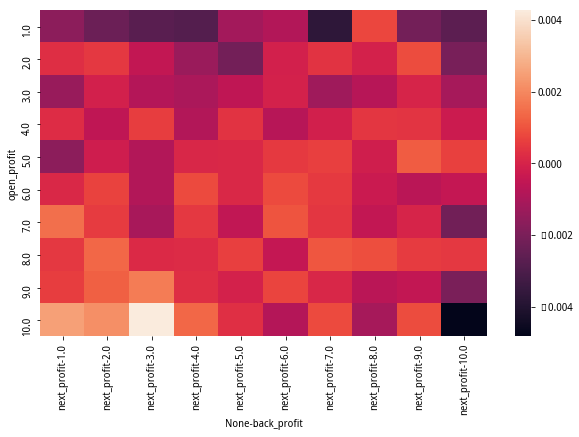

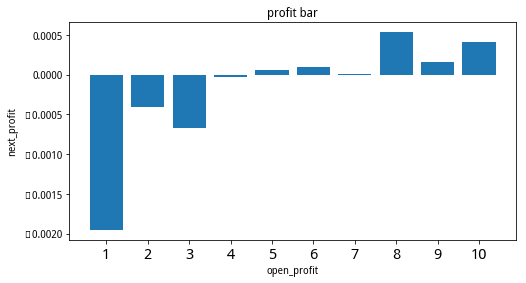

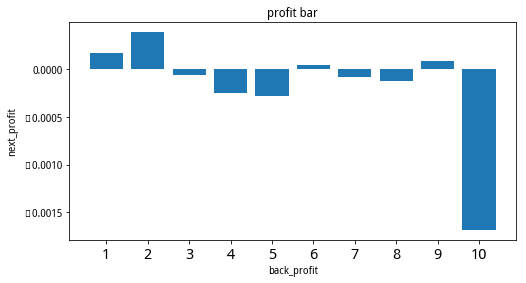

In [16]:
sel_data = combine_data(dic_res,sel_percent)
cut_res = cut_data(sel_data,cut_layer)

draw_heatmap(cut_res)

d = cut_res[['open_profit','next_profit']]
draw_bar(d)
back_next = cut_res[['back_profit','next_profit']]
t = draw_bar(back_next)

In [17]:
#对每一天的数据分组，多天数据合并

def get_day_profit(day_data,date,sel_n):
    '''
    获取每天的收益列表，
    '''
    day_data = day_data.dropna()
    new_col = ['back_profit','open_profit','next_profit']
    day_data = day_data[new_col]
    #删除开盘没有涨跌的股票
    sel_data = day_data[day_data['open_profit'] == 0].index
    day_data = day_data.drop(sel_data,axis=0) 
    cut_day_data = cut_data(day_data,cut_layer)
    col = cut_day_data.columns
    #选出对应股票
    #sel_day_data = cut_day_data[col[0]][cut_day_data[col[0]] == sel_n] 
    #sel_day_stocks = list(sel_day_data.index) 

    group_day_data = cut_day_data.groupby(['open_profit']).mean()
    day_profit = group_day_data.iloc[sel_n-1,-1]
    day_profit = pd.DataFrame([day_profit],index=[date],columns=['profit'])
    return day_profit

keys = list(dic_res.keys())
day_data = dic_res[keys[4]]
get_day_profit(day_data,keys[4],10)

,profit
2017-01-09,-0.000002


In [23]:
#选择每天的分层数据中收益较高的层
sel_n = 8
day_profit_l = []
for key in keys:
    day_data = dic_res[key]
    day_profit = get_day_profit(day_data,key,sel_n)
    day_profit_l.append(day_profit)
profit_df = pd.concat(day_profit_l)


              profit  cum_profit  base_profit
2019-08-29 -0.002238    0.939942     1.134030
2019-08-30 -0.006101    0.934207     1.136843
2019-09-02  0.004045    0.937986     1.151423
2019-09-03  0.003775    0.941527     1.153006
2019-09-04  0.006184    0.947350     1.162697


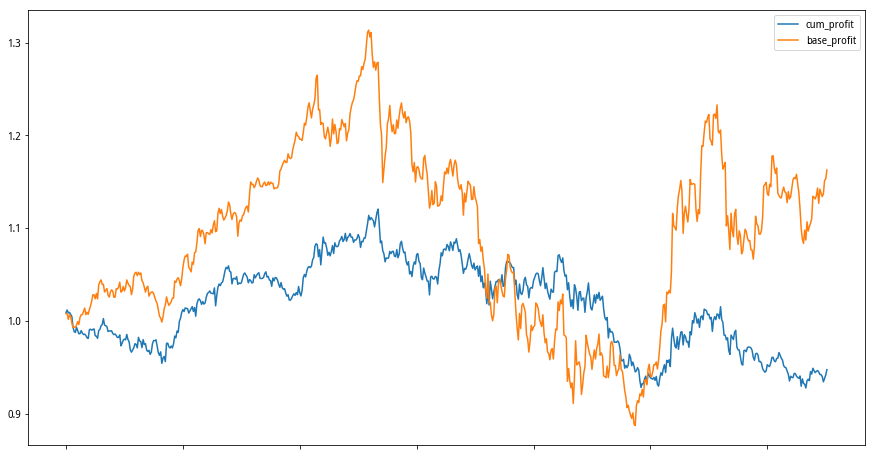

base profit is: 16.27%
strage profit is: -5.27%
max drawdown is: 17.22%


In [24]:
index = list(profit_df.index)
base_start_date = index[0]
base_end_date = index[-1]
base_price = get_price('000300.XSHG',start_date=base_start_date,end_date = base_end_date,fields=['close'])['close']
profit_df['cum_profit'] = (profit_df['profit'] + 1).cumprod()
#计算基准收益，以沪深300为准
base_price = get_price('000300.XSHG',start_date=base_start_date,end_date = base_end_date,fields=['close'])['close']
base_pofit = base_price.pct_change().dropna()
base_profit_cump = (base_pofit + 1).cumprod()
index = list(base_profit_cump.index)
new_index = [datetime.datetime.strftime(i,'%Y-%m-%d') for i in index ]
base_profit_cump.index = new_index
base_profit_cump.name = 'base_profit'

profit_df_combine = pd.concat([profit_df,base_profit_cump],axis=1).dropna()
print(profit_df_combine.tail())

draw_profit = profit_df_combine[['cum_profit','base_profit']]
draw_profit.plot(figsize=(15,8))
plt.show()
base_profit_show = profit_df_combine['base_profit'][-1]
stratage_profit_show = profit_df_combine['cum_profit'][-1]
print('base profit is: %s'%(str(round((base_profit_show-1)*100,2)) + '%'))
print('strage profit is: %s'%(str(round((stratage_profit_show-1)*100,2)) + '%'))

max_drawdown = find_max_drawdown(profit_df_combine['cum_profit'])
print('max drawdown is: %s' %(str(round(max_drawdown*100,2)) + '%'))